# *On the predictability of infectious disease*, Samuel V. Scarpino & Giovanni Petri

In order to study the predictability of our time-series, we employ permutation entropy as a model-free measure of time-series predictability. The **Permutation Entropy** (PE) of a time-series $\{x_t\}$ is given by the Shannon entropy on the permutation orders, that is: 

$$H^p(\{x_t\}) = - \sum_\pi p_{\pi} log(p_{\pi})$$ 

where $p_{\pi}$ is the probability of encountering the pattern associated with permutation $\pi$. The patterns are obtained from the time-series defining an embedding dimension $m$ and following the scheme (with $m = 3$):

<img src="./images/PE.png" width="400">

Finally, the metric used is the predictability defined as $\chi = 1 - H^p$. The closer to 1 the $\chi$ is, the more regular and more deterministic the time series is. Contrarily, the smaller $\chi$ is, the more noisy and random the time series is. A time-serie that visits all the possible symblos with equal frequency will have maximal entropy and minimal predictability, and a time-series that only samples a few of the possible symbols will instead have lower entropy and hence be more predictable.

In [1]:
import PermutationEntropy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

In [2]:
# Set default setting for the figures.
plt.style.use("default") # style matplotlib
plt.rc("axes", labelsize = 12) # fontsize of the x and y labels
plt.rc("axes", titlesize = 15) # fontsize of the axes title
plt.rc("xtick", labelsize = 12) # fontsize of the tick labels
plt.rc("ytick", labelsize = 12) # fontsize of the tick labels
plt.rc("legend", fontsize = 12) # legend fontsize

In [3]:
COUNTRY = "Niger"

In [4]:
df = pd.read_csv(f"../Data Sources/2. Food Consumption Score (FCS)/output_timeseries/{COUNTRY}/wfp_fcs-interpolate.csv", index_col = 0, header = [0, 1])
df.index = pd.to_datetime(df.index)
df.index.name = "Datetime"
df.index.freq = "D"
df.head()

AdminStrata,Agadez,Diffa,Dosso,Maradi,Niamey,Tahoua,Tillaberi,Zinder
Indicator,FCG,FCG,FCG,FCG,FCG,FCG,FCG,FCG
Datetime,,,,,,,,
2019-09-29,16.51505,55.65889,37.29881,44.98886,27.50424,46.53240,55.95156,40.83558
2019-09-30,16.12022,55.73581,36.98820,44.77407,29.05512,46.66547,56.10687,42.83007
2019-10-01,16.12022,55.87342,36.23385,44.49161,29.05512,47.37671,56.16133,43.36671
2019-10-02,16.12022,55.73192,36.23385,44.46598,29.05512,46.49170,55.73797,43.36671
2019-10-03,15.79652,55.37954,36.23385,44.85794,28.71595,46.77419,57.35720,43.36671


What value of the embedding dimension use for the these time-series? In order to find the appropriate embedding dimension for clustering a set of time-series (the FCS time-series in our case), we calculate the average normalized entropy of a set of distributions. The value of the $H^p$ should always decline as the embedding dimension grows, i.e. no minimum value of $H^p$ will exist for finite time-series. To address this issue, we follow Brandmaier and exclude all unobserved symbols when calculating $H^p$, which acts as a penalty against higher dimensions and results in a minimum value of $H^p$ for finite length time-series. To control for differences in dimension and for the effect of time-series length on the entropy estimation, we normalize the entropy by the log number of observed symbols.

The embedding dimension $m$ of a time-series is the length of the basic blocks used in the calculation of the permutation entropy, *it encodes the fundamental temporal unit of predictability* in the form of an entropy production rate. The result that predictability depends on temporal scale also suggests that the permutation entropy could be an approach for justifying the utility of different data sets, i.e. **one could determine the optimal granularity of data by selecting the dimension that maximized predictability**.

In [5]:
ms = np.arange(2, 21)

In [6]:
tqdm.pandas()
embedding_search = df.progress_apply(lambda x: PermutationEntropy.search_best_m(x, ms))
embedding_search.head()

AdminStrata,Agadez,Diffa,Dosso,Maradi,Niamey,Tahoua,Tillaberi,Zinder
Indicator,FCG,FCG,FCG,FCG,FCG,FCG,FCG,FCG
2,0.964242,0.996674,0.961237,0.998523,0.971215,0.999631,0.998523,0.981831
3,0.931097,0.927263,0.907845,0.937599,0.910830,0.954072,0.939959,0.947171
4,0.888508,0.864649,0.870067,0.883407,0.877739,0.907166,0.882407,0.900321
5,0.885268,0.860187,0.861029,0.874273,0.870746,0.871640,0.861094,0.890917
6,0.923641,0.906429,0.908087,0.906807,0.919496,0.911943,0.903463,0.928461


In [7]:
best_m = embedding_search.mean(axis = 1).idxmin()
best_m

5

Now, we turn our attention to the FCS indicator (composed by adminstrata-level time-series) and ask how the predictability, defined as $\chi = 1 - H^p$, scales with the amount of available data (i.e. the time-series length). Specifically, we compute the permutation entropy across the FCS dataset of the Yemen country and plotting the predictability as a function of the length of each time-series. Focusing on the predictability over short timescales for each time-serie, we average $H^p$ over temporal windows of width up to 100 days by selecting 1000 random points from each adminstrata-level time-series and calculating $H^p$ for windows of length 10, 12, ..., 100 days. Plotting, the solid lines indicate the mean value and the shaded region marks the interquartile range across all adminstrata and starting locations in the time-series.

In the paper, they find that all diseases show a clear decrease in predictability with increasing time-series length, which implies that accumulating longer stretches of time-series data for a given disease does not translate into improved predictability.

In [8]:
# Define the number of iteration you want to perform.
n_iter = 1000
# The min length of the temporal window to generate the subsample time-series.
min_window_length = 10
# The max length of the temporal window to generate the subsample time-series.
max_window_length = 100

ms = np.arange(2, 7 + 1) # Find the best embedding dimension for each iteration.

In [9]:
tqdm.pandas()
results = df.groupby(axis = 1, level = [0, 1]).progress_apply(lambda x: PermutationEntropy.PE_scaling_with_amount_of_data(x, n_iter, ms))
results.head()

AdminStrata    Agadez            Diffa            Dosso           Maradi  ...  \
Indicator         FCG              FCG              FCG              FCG  ...   
Parameter          PE   n  m        PE   n  m        PE   n  m        PE  ...   
0            0.877050  80  4  0.675521  31  3  0.909144  57  3  0.904030  ...   
1            0.746337  23  4  0.909579  26  3  0.764205  10  2  0.935525  ...   
2            0.940374  24  3  0.863306  99  4  0.843564  95  4  0.809147  ...   
3            0.873692  20  3  0.779350  14  2  0.835924  92  4  0.907150  ...   
4            0.643154  85  4  0.566510  16  2  0.955434  31  3  0.881697  ...   

AdminStrata Niamey    Tahoua        Tillaberi           Zinder         
Indicator      FCG       FCG              FCG              FCG         
Parameter        m        PE   n  m        PE   n  m        PE   n  m  
0                4  0.922087  85  4  0.814185  51  4  0.803838  32  4  
1                4  0.920848  50  4  0.804319  58  4  0.900430  57  4  
2                3  0.876792  49  4  0.812543  21  4  0.910099  88  4  
3                3  0.817959  54  4  0.840009  35  4  0.820874  12  3  
4                4  0.914154  90  4  0.789739  22  3  0.887884  74  4  

[5 rows x 24 columns]

In [10]:
results = results.stack([0, 1]).droplevel(axis = 0, level = 0)
results.head()

,Parameter,PE,m,n
AdminStrata,Indicator,,,
Agadez,FCG,0.877050,4,80
Diffa,FCG,0.675521,3,31
Dosso,FCG,0.909144,3,57
Maradi,FCG,0.904030,3,30
Niamey,FCG,0.911672,4,88


In [11]:
y = results["PE"]
x = results["n"]

ent = y.groupby(by = x).apply(np.mean).values
ent_low = y.groupby(by = x).apply(lambda x: x.quantile(q = 0.25)).values
ent_high = y.groupby(by = x).apply(lambda x: x.quantile(q = 0.75)).values
n = y.groupby(by = x).apply(np.mean).index

results = pd.DataFrame({"Chi": 1 - ent, "n": n, "Chimax": 1 - ent_low, "Chimin": 1 - ent_high})
results.head()

,Chi,n,Chimax,Chimin
0,0.225258,10,0.323008,0.081704
1,0.277315,11,0.358698,0.118709
2,0.277637,12,0.337393,0.154649
3,0.288992,13,0.423158,0.136827
4,0.250058,14,0.337548,0.153287


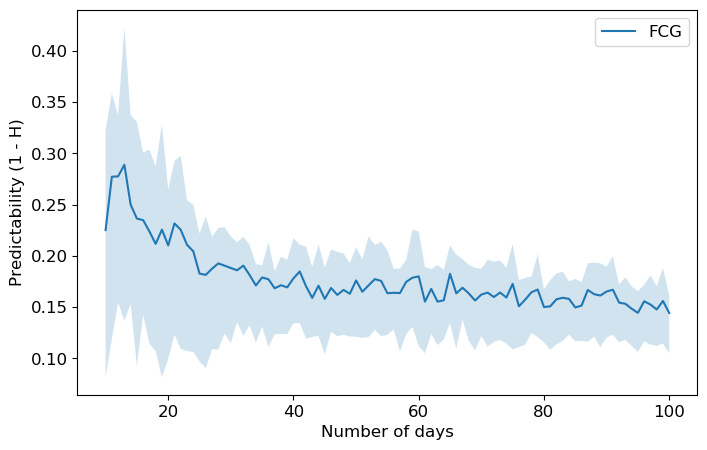

In [12]:
f = plt.figure(figsize = (8, 5))
results.plot(ax = f.gca(), x = "n", y = "Chi", label = "FCG")
plt.fill_between(x = "n", y1 = "Chimax", y2 = "Chimin", data = results, alpha = 0.2)
plt.ylabel("Predictability (1 - H)")
plt.xlabel("Number of days")
plt.autoscale()

f.savefig(f"./output_images/{COUNTRY}.png" , bbox_inches = "tight", dpi = 300)